# Earth Systems Modeling Group
# Model Development and Testing

Charlotte Cherry

### Extended Data Analysis

In [3]:
#Import the necessary packages for this code
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime
import matplotlib.pyplot as plt

In [9]:
#Import the training and testing datasets
train = pd.read_csv('../input/cee-498-project12-earth-system-model/train.csv')
test = pd.read_csv('../input/cee-498-project12-earth-system-model/test.csv')

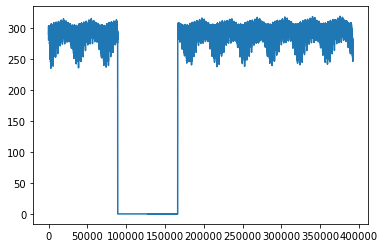

In [10]:
#Plot of the target variable in the training data demonstrates a set of outlier values.
train['TSA'].plot();

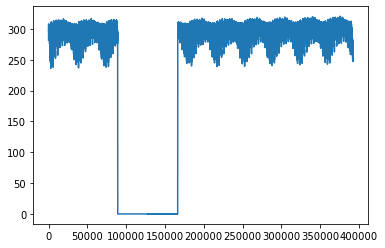

In [11]:
#These same outliers appear in the ground temperature variable (TG)
train['TG'].plot();

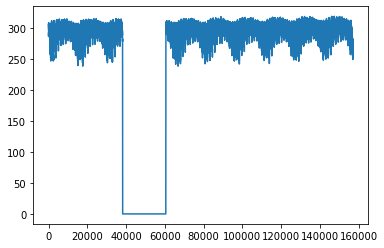

In [12]:
#When we examine TG in the testing dataset, it follows the same pattern. Thus, it is likely that TSA in the testing set also has outliers.
test['TG'].plot();

Given these identified relationships, we hope that by keeping the outliers in the dataset, the model will be able to connect outliers in other variables to the outliers in the target variable.

# Model Choice

Choosing the appropriate model type is an important set in the process. The question we are trying to answer is whether machine learning approaches could be used to predict earth model outputs accurately based on other values. Given the complexity of earth system models, it is computationally expensive to run many scenarios for these models. Machine learning could identify patterns or use some input parameters to predict outputs like temperature, and this would could be significantly less computationally intense. We want to be able to utilize a set of independent variables to predice the target variable (surface temperature or "TSA") at any point.

Our dataset is primarily numerical values and the problem faced is a regression problem to identify the relationship between numerous variables. While it is similar to a timeseries because the data are for ordered months over years, we are not using it for timeseries predictions. We are not using enough data to complete this type of analysis. If we were, a Recurrent Neural Network would probably work well.

Both Random Forest and Neural Network models can be used for regressions like the one we are trying to create. Random Forests could work well for this dataset and are simplier to build. Our feature variables are simple numerical values and a Random Forest model can identify nonlinear relationships. However, Random Forests are bounded by the range of the highest and lowest labels in the training data. Thus, if we wanted to extrapolate the data we have into the future, this would not be a good option. 

In addition, Neural Networks are able to regonize patterns in the data and utilize given inputs to produce the output variable of interest. The network trains by trying to produce outputs that match the known outputs based on a system of weights. This seems like a promising approach to try as well.

Therefore, it seems optimal to try to build a Random Forest model and a Neural Network to compare the outputs.

# Methods

The first attempt was to build a Random Forest model based on variables identified in the EDA.

In [4]:
#Import the training and testing datasets
train = pd.read_csv('../input/cee-498-project12-earth-system-model/train.csv')
test = pd.read_csv('../input/cee-498-project12-earth-system-model/test.csv')

In [5]:
train['time']=pd.to_datetime(train['time'])
train['year']=train['time'].dt.year

In [6]:
#Drop unnecessary columns, including those that are objects
train.drop(columns=['area', 'date_written', 'landfrac', 'landmask', 'mcdate', 'mcsec', 'mdcur', 'mscur', 'nbedrock', 'nstep', 'pftmask', 'time_written', 'SNOW_PERSISTENCE', 'time'], axis=1, inplace=True)

In [7]:
#Drop the rows from the training set where the target is nan
train = train[train['TSA'].notna()]

In [8]:
#Clean the dataset for training
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), 'df needs to be a pd.Dataframe'
    indices_to_keep = ~df.isin([np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)
train=clean_dataset(train)
train

,lat,lon,ACTUAL_IMMOB,AGNPP,ALT,ALTMAX,AR,ATM_TOPO,BAF_CROP,BAF_PEATF,...,WOOD_HARVESTC,WOOD_HARVESTN,WTGQ,XSMRPOOL,XSMRPOOL_RECOVER,ZBOT,ZWT,ZWT_CH4_UNSAT,ZWT_PERCH,year
0,-55.130890,291.25,3.187791e-07,2.019572e-06,41.998436,41.998436,3.137603e-05,107.523200,0.0,0.000000e+00,...,8.622255e-14,3.008571e-16,0.011096,-18.430012,5.077611e-06,30.0,0.679997,8.600000e+00,8.03,2015.0
1,-54.188480,292.50,2.703498e-07,1.482404e-06,41.998436,41.998436,5.729507e-05,115.647125,0.0,0.000000e+00,...,0.000000e+00,0.000000e+00,0.004370,-27.031332,7.277672e-06,30.0,8.576626,8.600000e+00,8.03,2015.0
2,-53.246075,288.75,3.247867e-07,3.837039e-06,41.998436,41.998436,5.175082e-05,162.261490,0.0,0.000000e+00,...,4.798560e-13,1.574547e-15,0.006048,-30.051014,7.530587e-06,30.0,8.482937,8.600000e+00,8.03,2015.0
3,-53.246075,291.25,1.079573e-07,1.714547e-06,41.998436,41.998436,6.618094e-05,141.726430,0.0,0.000000e+00,...,0.000000e+00,0.000000e+00,0.003439,-30.347467,7.589988e-06,30.0,8.599994,8.600000e+00,8.03,2015.0
4,-51.361256,291.25,4.048082e-07,3.667290e-06,41.998436,41.998436,1.413142e-05,30.983973,0.0,0.000000e+00,...,1.051186e-12,3.767686e-15,0.010660,-17.847149,4.376521e-06,30.0,8.600000,8.600000e+00,8.03,2015.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392113,68.324608,32.50,1.865284e-07,6.143616e-06,41.998436,41.998436,7.673205e-06,161.148480,0.0,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000056,-103.447680,0.000000e+00,30.0,2.075583,6.084516e+00,0.01,2096.0
392114,69.267014,18.75,8.128914e-08,2.729918e-06,41.998436,41.998436,3.468702e-06,408.132930,0.0,1.241571e-33,...,0.000000e+00,0.000000e+00,0.000033,-72.102500,1.299642e-07,30.0,0.920000,1.476667e-08,0.01,2096.0
392115,69.267014,32.50,2.245720e-07,3.065793e-06,41.998436,41.998436,3.885988e-06,139.022380,0.0,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000055,-81.472450,0.000000e+00,30.0,1.562245,3.171048e+00,0.01,2096.0
392116,69.267014,87.50,3.406791e-08,5.550059e-08,41.998436,41.998436,1.612993e-07,135.889620,0.0,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000029,-45.448140,0.000000e+00,30.0,2.720000,0.000000e+00,0.01,2096.0


Since we do not have the solutions for the target variable in the testing data, it is best to find a way to test the results of the model. This requires separating the training data into two sections. The dataset is large, so this does not present any problems. A validation set is made with the last three years of data of 15 within the dataset. This was done because the literature describes that validation sets made from randomly chosen points are often not effective for data that are in a timeseries. While we are not doing a timeseries analysis, the data follow a cyclical pattern. The annual and monthly variation is very apparent in the exploratory data analysis. If random points are taken, it may be too easy for the model to identify the pattern without training in a robust way. The alternative would be to implement a split that randomly chooses a validation set from the testing data using the code below. 

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

This method was also tested and the results were not significantly different but the chosen approach did reduce the losses.

In [9]:
#Create a validation set that is the last 3 years of data
validation_set = train[train['year'] == 2086]
year_2095 = train[train['year'] == 2095]
year_2096 = train[train['year'] == 2096]
validation_set = validation_set.append(year_2095)
validation_set = validation_set.append(year_2096)

#Check validation set
validation_set

#Training set is all of the earlier years
train_set = train.query('year < 2086')

We are interested in running the training the model based on certain variables within the dataset that could have the best predictive capacity. The dataset is so large that using all of the features is computationally very difficult. The primary columns used for predicting in the first round come from the variables considered in the EDA.

In [19]:
#The prediction variables were selected based off of those with high correlations to TSA from the EDA and additional variables related to radiation, rain, and wind that were considered important for predicting temperature
predictor_cols = ['lat','lon', 'FIRE_ICE', 'SOILWATER_10CM', 'SWBGT','SWBGT_R','SWBGT_U','TBOT','TBUILD','TG','TG_ICE','TH2OSFC','THBOT','TOPO_COL_ICE','TREFMNAV','TREFMXAV','TSA_ICE','TSKIN','TSL','TSOI_10CM','TV','Vcmx25Z','WA','ZBOT','ZWT_CH4_UNSAT','ZWT_PERCH','U10','SABG','RH2M','HUMIDEX','FSA', 'FSDS', 'FLDS', 'RAIN', 'PBOT','QBOT']


Then, we set up the training inputs based on these predictive variables. The dependent variable we are trying to find is TSA or surface temperature. Both the training dataset and the validation dataset must be divided into the independent and dependent variable columns.

In [20]:
#Independent/feature variables
X = train_set[predictor_cols]
my_imputer = SimpleImputer()
train_X=my_imputer.fit_transform(X)

#Dependent variable
train_y = train_set.TSA

#Create the validation set variables
val_X = validation_set[predictor_cols]

val_y = validation_set.TSA

We try to run a random forest regression model to predict the dependent variable.

In [21]:
my_model = RandomForestRegressor()
my_model.fit(train_X, train_y)

RandomForestRegressor()

The same process must be done on the validation variables to compare the predicted values to the observed.

In [22]:
val_X = validation_set[predictor_cols]
my_imputer = SimpleImputer()
val_X=my_imputer.fit_transform(val_X)

In [23]:
#Make a prediction of the target variable in the validation set
validation_p_y = my_model.predict(val_X)

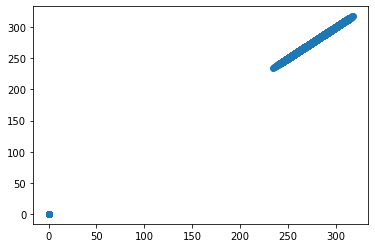

In [24]:
#Plot the predicted training variables compared to the observed.
plt.scatter(train_y, my_model.predict(train_X))

In [25]:
#Find the root mean squared error for the validation set
tf.keras.metrics.RootMeanSquaredError()(val_y, validation_p_y)

<tf.Tensor: shape=(), dtype=float32, numpy=0.086208194>

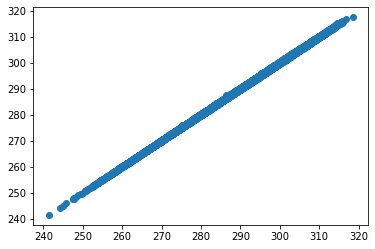

In [26]:
#Plot the validation observations vs. the model predictions
plt.scatter(val_y, my_model.predict(val_X))

We can see that the model is doing a good job predicting the validation TSA, given the very small root mean squared error (0.086). In previous runs of the model, the error was even lower, around 0.072. In addition, the plots of the observed vs. predicted values in the training and validation datasets show veyr high correlation. 

The following code runs the model against the test data and produces the submission.

In [27]:
test_X = test[predictor_cols]
test_X = my_imputer.fit_transform(test_X)

predicted_tsa = my_model.predict(test_X)

predicted_tsa

my_submission = pd.DataFrame({'index': test['index'], 'TSA':predicted_tsa})
my_submission.to_csv('submission1.csv', index=False)

### Attempt 2 - Removing temperature-based independent variables

The results of the Random Forest model above are almost too good. The model is predicting almost exactly the temperature in the testing data. Thus, it is important to consider whether our model is including information that makes it too easy for the model to make it's prediction and is therefore not fully robust.

As we found in the EDA, some of the other variables in this dataset are very strongly correlated with the target variable (TSA), such as ground temperature, skin temperature, atmospheric air temperature. However, being able to predict TSA using other temperature variables may not be of great use from a practical standpoint to answer the scientific question. So, here we want to remove some of the predictive variables that are too closely correlated to the desired variable and see if we are still able to produce valuable results.

We will remove:
* TG 
* TG_ICE
* TSKIN
* TSA_ICE
* TBOT
* TV
* THBOT
* TREFMNAV
* TSL
* TSOI_10CM
* TREFMXAV
* TH2OSFC
* TBUILD

These variables were all found to have close to 0.999 correlation with TSA during the EDA.

In [28]:
#Define the new predictive columns
predictor_cols2 = ['lat','lon', 'FIRE_ICE', 'SOILWATER_10CM', 'SWBGT','SWBGT_R','SWBGT_U','TOPO_COL_ICE','Vcmx25Z','WA','ZBOT','ZWT_CH4_UNSAT','ZWT_PERCH','U10','SABG','RH2M','HUMIDEX','FSA', 'FSDS', 'FLDS', 'RAIN', 'PBOT','QBOT']


We also tried using the alternative training/validation set split to see whether it would still work.

In [29]:
#Independent/feature variables
#The simple imputer is used to fill missing values in the dataset.
X = train[predictor_cols2]
my_imputer = SimpleImputer()
X = my_imputer.fit_transform(X)

#Dependent variable
y = train.TSA

#Establish the training and validation set based off of a random split
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

The model is run again with the new variable set.

In [30]:
my_model = RandomForestRegressor()
my_model.fit(train_X, train_y)

RandomForestRegressor()

In [31]:
validation_p_y = my_model.predict(val_X)

validation_p_y

array([291.6235217, 305.2755723, 296.2635003, ..., 288.3912149,
       289.3031856,   0.       ])

In [32]:
tf.keras.metrics.RootMeanSquaredError()(val_y, validation_p_y)

<tf.Tensor: shape=(), dtype=float32, numpy=0.084540755>

<tf.Tensor: shape=(), dtype=float32, numpy=0.084540755>

We can see that the results of this attempt are actually improved from the first attempt. The error is still very low and the model is doing a good job predicting the target variable.

### Attempt 3 - Fewer predictive columns

As in the previous example, the third attempt is to cut down the predictive columns even more. The columns that are included are more independent of temperature and none of the temperature-related variables are included.

In [38]:
predictor_cols3 = ['lat','lon', 'ZWT_CH4_UNSAT','ZWT_PERCH','U10','SABG','RH2M','FSA', 'FSDS', 'FLDS', 'RAIN', 'PBOT','QBOT']


In [39]:
#Independent/feature variables
#The simple imputer is used to fill missing values in the dataset.
X = train[predictor_cols3]
my_imputer = SimpleImputer()
X = my_imputer.fit_transform(X)

#Dependent variable
y = train.TSA

#Establish the training and validation set based off of a random split
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.3, random_state = 0)

In [40]:
my_model = RandomForestRegressor()
my_model.fit(train_X, train_y)

RandomForestRegressor()

In [41]:
validation_p_y = my_model.predict(val_X)

validation_p_y

array([291.3339349, 305.2666328, 296.8991058, ..., 287.9518736,
       289.0461337,   0.       ])

In [42]:
tf.keras.metrics.RootMeanSquaredError()(val_y, validation_p_y)

<tf.Tensor: shape=(), dtype=float32, numpy=0.43721363>

Simplifying the independent variables further and using a smaller list of variables resulted in a larger error (rmse =  0.437) that is much larger than in the previous attempts. This indicates the power of those variables in the model. However, the error even in this case is not very large.

### Attempt 4 - Improved hyperparameters

Based on the same predictor columns as above, the various hyperparameters were tested to see if a different combination would yield better results. The only hyperparameter that had signfiicant effects on the model results was n_estimator, with an optimal value of around 300. The other hyperparameters did not have significant impacts on the error.

In [10]:
predictor_cols4 = ['lat','lon', 'ZWT_CH4_UNSAT','ZWT_PERCH','U10','SABG','RH2M','FSA', 'FSDS', 'FLDS', 'RAIN', 'PBOT','QBOT']

In [11]:
#Independent/feature variables
#The simple imputer is used to fill missing values in the dataset.
X = train[predictor_cols4]
my_imputer = SimpleImputer()
X = my_imputer.fit_transform(X)

#Dependent variable
y = train.TSA

#Establish the training and validation set based off of a random split
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.3, random_state = 0)

In [12]:
my_model = RandomForestRegressor(n_estimators=300)
my_model.fit(train_X, train_y)

RandomForestRegressor(n_estimators=300)

In [13]:
validation_p_y = my_model.predict(val_X)

validation_p_y

array([291.36300813, 305.477324  , 297.02745057, ..., 287.70262753,
       288.47628093, 302.08550813])

In [14]:
tf.keras.metrics.RootMeanSquaredError()(val_y, validation_p_y)

<tf.Tensor: shape=(), dtype=float32, numpy=0.44007346>

Using these improved hyperparameters, we get an improved result over the previous attempt (the rmse is now around 0.44). The attempts previously that included additional independent variables far outperformed this model, however. 

## Neural Network

The parameters, such as learning rate and batch size, and the number of hidden layers/units within the layers were adjusted to reduce the mean squared error and the mean absolute error.

In [5]:
#train_df = pd.read_csv('../input/cee-498-project12-earth-system-model/train.csv')
#test_df = pd.read_csv('../input/cee-498-project12-earth-system-model/test.csv')
train_df = pd.read_csv(r'C:\Users\ckpch\Documents\University of Illinois Classes\Fall 2020\Data Science\Project\train.csv')
test_df = pd.read_csv(r'C:\Users\ckpch\Documents\University of Illinois Classes\Fall 2020\Data Science\Project\test.csv')

In [6]:
#Define the new predictive columns
predictor_cols = ['lat','lon', 'FIRE_ICE', 'SOILWATER_10CM', 'SWBGT','SWBGT_R','SWBGT_U','TOPO_COL_ICE','Vcmx25Z','WA','ZBOT','ZWT_CH4_UNSAT','ZWT_PERCH','U10','SABG','RH2M','HUMIDEX','FSA', 'FSDS', 'FLDS', 'RAIN', 'PBOT','QBOT']
label = ['TSA']
my_imputer = SimpleImputer()

#Independent/feature variables
#The simple imputer is used to fill missing values in the dataset.
X = train_df[predictor_cols]
X = my_imputer.fit_transform(X)
X = pd.DataFrame(X, columns=[predictor_cols])

y = my_imputer.fit_transform(train_df[label])
y=pd.DataFrame(y, columns=[label])

test_X = my_imputer.fit_transform(test_df[predictor_cols])
test_X=pd.DataFrame(test_X, columns=[predictor_cols])

#Establish the training and validation set based off of a random split
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.3, random_state = 0)

In [7]:
#Use scaler to normalize the data for the neural network
scaler = StandardScaler()
scaler.fit(train_X)
train_X_sc = scaler.transform(train_X)
scaler2 = StandardScaler()
scaler2.fit(val_X)
val_X_sc = scaler2.transform(val_X)
#Create tensors
train_tensor = tf.data.Dataset.from_tensor_slices((train_X_sc, train_y.values)).shuffle(80).batch(10)
validation_tensor = tf.data.Dataset.from_tensor_slices((val_X_sc, val_y.values)).shuffle(80).batch(10)

In [8]:
def create_model(my_learning_rate):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(1))

    model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate), loss = 'mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

In [9]:
#Set hyperparameters
learning_rate = 1e-4
epochs = 20
batch_size = 100

label_name = 'TSA'

my_model = create_model(learning_rate)

In [10]:
history = my_model.fit(train_tensor, validation_data = validation_tensor, batch_size=batch_size, epochs=epochs, shuffle=True)

epochs=history.epoch

hist = pd.DataFrame(history.history)
rmse = hist['root_mean_squared_error']

Epoch 1/20

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

27449/27449 [==============================] - 60s 2ms/step - loss: 1723.1836 - root_mean_squared_error: 41.5112 - val_loss: 3.2905 - val_root_mean_squared_error: 1.8140
Epoch 2/20
27449/27449 [==============================] - 58s 2ms/step - loss: 1.6195 - root_mean_squared_error: 1.2726 - val_loss: 1.1104 - val_root_mean_squared_error: 1.0537
Epoch 3/20
27449/27449 [==============================] - 50s 2ms/step - loss: 0.7823 - root_mean_squared_error: 0.8845 - val_loss: 0.8780 - val_root_

Epoch 20/20
27449/27449 [==============================] - 46s 2ms/step - loss: 0.0825 - root_mean_squared_error: 0.2872 - val_loss: 0.2933 - val_root_mean_squared_error: 0.5415

In [15]:
from sklearn.metrics import mean_squared_error
predicted_y = my_model.predict(val_X_sc)
root_mean_squared_error(val_y,predicted_y)**(1/2)

0.43957114656924673

The Neural Network also performed quite well on this data. The RMSQ is around 0.439, which is pretty close to the value received from the Random Forest. It appears that the training set receives a better fit but this could mean there is overfitting. The RMSE is higher in this run than some of the Random Forest examples but it does perform better than some of the other runs with fewer variables. Additional tuning and improvements could be made to make the performance even better.

# Results

The results indicate that both Random Forest and Neural Network models could be used to complete this model with high levels of accuracy. Both demonstrated good performance on the dataset. However, the Random Forest performed better even when fewer variables were used as inputs. In addition, the Neural Network was more computationally difficult to run on such a large dataset, which shows that it is likely not worth using this type of model for the scientific question. The Random Forest received a very low error score of around 0.084 on some runs, and even lower on others. The results of the model also depend on the input variables or independent variables considered in the model. As discussed earlier, there are some variables closely tied to temperature which make it too easy for the model to predict the target variable. 

These results show that the best option for the model would be a Random Forest using n_estimator value of around 300.

# Discussion

While all group members attempted to create neural networks independently and using different approaches. However, there were issues with exploding gradients and generally the predictions were not as good as using a Random Forest. It is possible that a properly tuned Neural Network would perform better on this dataset, particularly if the goal was to use this model to extrapolate on known data and make predictions about how climate change will drive future changes in temperature, as this type of extrapolation would not be possible using a Random Forest.

In addition, handling this dataset is extremely computationally difficult. Running the models takes a lot of time and sometimes crash the memory and CPU capacity of the platforms. Therefore, it would be best to try to find ways to cut down the dataset and only include the minimum number of variables necessary to make predictions. This would help allow for model speed to increase.